# Preprocessing mit Blaufilter

Als Preprocessing können wir eine Blaufilter einbauen. Die Idee dahinter ist, dass wir das Model zwingen, sich auf die blaue Linie zu konzentrieren, in dem wir ihm die anderen Sachen im Kamerabild gar nicht als Input geben. Ein bisschen so wie [Scheuklappen](https://de.wikipedia.org/wiki/Scheuklappen) bei einem Pferd.

Dieses Notebook dient dazu, die optimalen Einstellungen für den Blaufilter sowie weiteren Optimierungen zu finden, welche dann im `06d_Fahrmodell_Training_mit_Blaufilter.ipynb` eingesetzt werden können.
**Wichtig:** Denke daran, die gleichen Einstellungen auch im `override_driving.py` zu machen!

In [71]:
# Als erstes laden wir alle benötigenden Libraries

from fastai.data.all import *
from fastai.vision.all import *

import json # Für das auslesen der Fahrdaten
import matplotlib.pyplot as plt # Für das Erstellen von Grafiken
import cv2 # Für das Filter von Bildern

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display, clear_output

import colorsys

## Bilderpfade laden

In [21]:
# mit Google Drive verbinden
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
image_directory_path = Path('/content/drive/MyDrive/AI-Challenge/daten/fahrmodell/tobias')

# Sollte der Pfad nicht existieren, wird hier eine Fehlermeldung ausgegeben
if not image_directory_path.exists():
    raise Exception(f"Fehler🛑 Der Pfad {image_directory_path} existiert nicht")
else:
    print(f"Alles gut👍 der Pfad {image_directory_path} wurde gefunden")

Alles gut👍 der Pfad /content/drive/MyDrive/AI-Challenge/daten/fahrmodell/tobias wurde gefunden


In [96]:
# alle Bildpfade laden
image_paths = get_image_files(image_directory_path)
print(f"Es wurden {len(image_paths)} Bilder gefunden")

# der erste Pfad auswählen und ausgeben (wenn du einen anderen willst, ändere den Index)
some_image_path = image_paths[1411]
print(some_image_path)


Es wurden 3927 Bilder gefunden
/content/drive/MyDrive/AI-Challenge/daten/fahrmodell/tobias/2023-10-24T14_34_27.036770.png


In [94]:
# Hilfsfunktionen und Variablen

def show_image(image_array):
    plt.imshow(image_array)
    # plt.show()
    # plt.grid(False)

def rgb2hex(r,g,b):
    return f"#{r:02X}{g:02X}{b:02X}"

def hex2rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return [r, g, b]

color_filtered = None
eroded = None
cropped = None

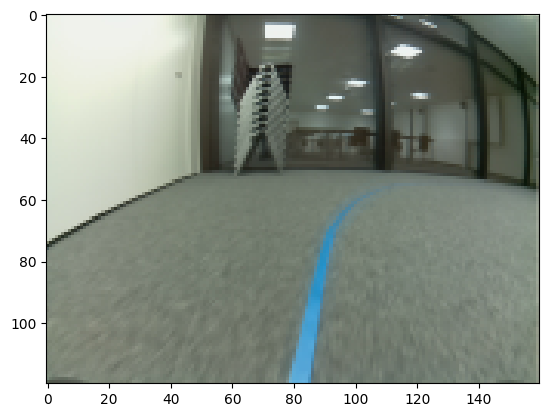

In [95]:
# Bild als array laden und Wertebereich sicherstellen (nötig für override_driving.py)
image_array = np.array(img)
if not image_array.dtype == np.uint8:
    image_array *= 255


# Bild anzeigen
show_image(image_array)

## Bild filter

Wir schauen uns nun der Reihe nach verschieden Filter an.

1. Farbfilter
2. Erosions-Filter (kleine Pixelbereiche entfernen)
3. Bildbereiche löschen

Verwende die Reglen, um optimale Werte für die Filter zu finden

### Farbfilter

Der Farbfilter verwendet eine untere und obere Grenze als Parameter.

Mehr Infos: https://docs.opencv.org/3.4/da/d97/tutorial_threshold_inRange.html

ColorPicker(value='#004B73', description='Lower')

ColorPicker(value='#73CDFF', description='Upper')

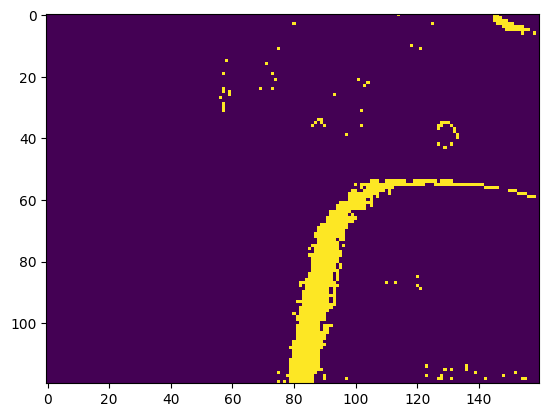

In [91]:
# Color Filter
def filter_callback(_):
  global color_filtered
  lower = np.array(hex2rgb(w_lower.value))
  upper = np.array(hex2rgb(w_upper.value))
  color_filtered = cv2.inRange(image_array, lower, upper)
  clear_output(wait=True)
  display(w_lower)
  display(w_upper)
  show_image(color_filtered)

# Farben auswählen
w_lower = widgets.ColorPicker(
    concise=False,
    description='Lower',
    value=rgb2hex(0, 75, 115),
    disabled=False
)

w_upper = widgets.ColorPicker(
    concise=False,
    description='Upper',
    value=rgb2hex(115, 205, 255),
    disabled=False
)

w_lower.observe(filter_callback)
w_upper.observe(filter_callback)

filter_callback(_)

## Pixel entfernen

Wie wir sehen, hat es ein paar verstreute Pixel, diese können wir "weg erodieren", sodass nur grössere Zusammenhängende Bereiche im Bild vorhanden sind.

IntSlider(value=2, description='Kernel-Grösse:', max=10, min=1)

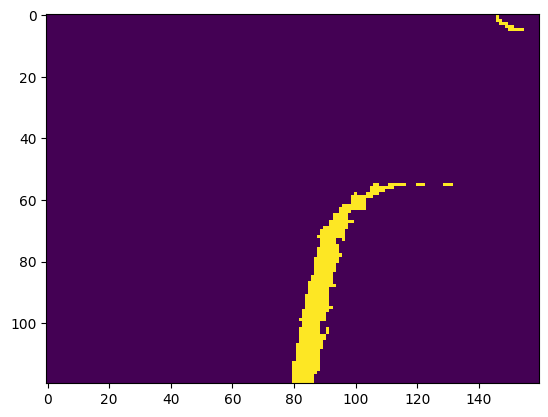

In [92]:
def erode_callback(_):
  global eroded
  kernel = np.ones((w_kernel.value, w_kernel.value), np.uint8) # <- Werte können angepasst werden, z.B. (4,4)
  eroded = cv2.erode(color_filtered, kernel, iterations=1)
  clear_output(wait=True)
  display(w_kernel)
  show_image(eroded)

# Kernel-Grösse wählen
w_kernel = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    description='Kernel-Grösse:',
    # disabled=False,
    # continuous_update=False,
    # orientation='horizontal',
    # readout=True,
    # readout_format='d'
)


w_kernel.observe(erode_callback)

erode_callback(_)

## Abschneiden

In unserem Fall wird der obere Bereich des Bildes vermutlich keine für das Fahren relevante Daten enthalten. Im Gegenteil, es ist gut möglich, dass sich dort etwas blaues befindet (Blaues Verkehrsschild, Himmel, Reflektionen in Fensterscheibe etc.) was unser Fahrmodell stört.

Um das zu vermeiden, können wir den oberen Teil des Bildes wegschneiden, respektive auf Null setzten.



IntSlider(value=50, description='Kernel-Grösse:', max=120)

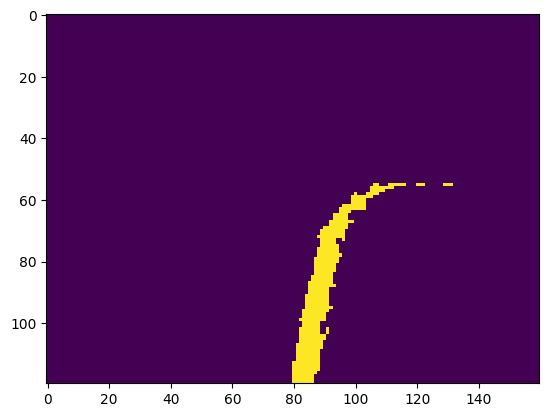

In [93]:
def crop_callback(_):
  global cropped
  cropped = eroded.copy()
  cropped[:w_crop.value, :] = 0
  clear_output(wait=True)
  display(w_crop)
  show_image(cropped)

# Kernel-Grösse wählen
w_crop = widgets.IntSlider(
    value=50,
    min=0,
    max=120,
    step=1,
    description='Kernel-Grösse:',
    # disabled=False,
    # continuous_update=False,
    # orientation='horizontal',
    # readout=True,
    # readout_format='d'
)


w_crop.observe(crop_callback)

crop_callback(_)

hast du optimale Werte gefunden? Dann kannst du diese Werte fürs Training und fürs Fahren verwenden